# Classification Analysis of GK Dives

## 1) Import Necessary Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, chi2 
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

## 2) Compiling Dataset

In [2]:
"""code was used on the original files extracted from the GPS trackers to
   compile them into a single dataframe and create a .csv file called 'All_GK_Dives.csv'"""

#f1 = pd.DataFrame()
#ath_dir = 'C:/Users/darag/Desktop/Final Year Project/'
#ll_files = os.listdir(path_dir)    
#sv_files = list(filter(lambda f: f.endswith('.csv'), all_files))

#summary_file = []
#for fil in csv_files:
#    print(path_dir + fil)
#    summary_file.append(path_dir + fil)

#for file in summary_file:
#    if os.path.exists(file): #if file exists:
#           df_summary = pd.read_excel(file, index_col = 0)
#           df1 = df1.append(df_summary, ignore_index=True, sort=False)
     
#file_name = df1.to_csv('All_GK_Dives.csv', index = True)

"code was used on the original files extracted from the GPS trackers to\n   compile them into a single dataframe and create a .csv file called 'All_GK_Dives.csv'"

### Reading in dataset and applying descriptive statistics

In [3]:
df1 = pd.read_csv('All_GK_Dives.csv')

# Get descriptive statistics on the DataFrame
stats = df1.describe()

# Display the descriptive statistics
print(stats)

#count the number of null values
null_df = df1.apply(lambda x: sum(x.isnull())).to_frame(name= 'count')
print(null_df)

        Unnamed: 0  Classification      Classes     Duration   Peak Acc x  \
count  6693.000000     6693.000000  1968.000000  6693.000000  6693.000000   
mean   3346.000000        0.293889     6.726626     1.448424     3.108194   
std    1932.247008        0.455576     3.517761     0.475012     3.239713   
min       0.000000        0.000000     1.000000     0.000000    -1.707024   
25%    1673.000000        0.000000     5.000000     1.100000     1.215852   
50%    3346.000000        0.000000     7.000000     1.500000     1.910520   
75%    5019.000000        1.000000    10.000000     1.800000     3.119784   
max    6692.000000        1.000000    14.000000     2.000000    15.988344   

        Mean Acc x   Peak Acc y   Mean Acc y   Peak Acc z   Mean Acc z  ...  \
count  6693.000000  6693.000000  6693.000000  6693.000000  6693.000000  ...   
mean      0.009835     4.532907     0.506030     3.758378     0.599714  ...   
std       0.359638     1.815327     0.498997     2.050036     0.29097

## 3) Adding the additional data to the goalkeeping dataframe

In [4]:
df1 = df1.rename(columns={'Folder Name': 'datetime'})
df1_weather = pd.read_csv('Hamburg-Arsenal-Colorado-Weather.csv')

combined_df = pd.DataFrame(columns=df1.columns)

# Iterate over the unique dates in the first dataframe
for date in df1['datetime'].unique():
    
    # Filter the data for the current date in the first dataframe
    filtered_df1 = df1[df1['datetime'] == date]
    
    # Filter the data for the current date in the second dataframe
    filtered_df2 = df1_weather[df1_weather['datetime'] == date]
    
    # Combine the data for the current date
    combined_data = pd.merge(filtered_df1, filtered_df2)
    
    
    # Append the combined data to the new dataframe
    combined_df = combined_df.append(combined_data)

# Display the combined data
print(combined_df)

    Unnamed: 0    datetime Start Time  End Time Classification  Classes  \
0            0  13/10/2020   00:16:09  00:16:11              0      NaN   
1            1  13/10/2020   00:17:10  00:17:11              0      NaN   
2            2  13/10/2020   00:17:14  00:17:16              1      7.0   
3            3  13/10/2020   00:17:17  00:17:18              1      3.0   
4            4  13/10/2020   00:17:44  00:17:46              0      NaN   
..         ...         ...        ...       ...            ...      ...   
118       6688  18/05/2021   00:52:43  00:52:45              0      NaN   
119       6689  18/05/2021   00:52:45  00:52:47              0      NaN   
120       6690  18/05/2021   00:52:47  00:52:48              0      NaN   
121       6691  18/05/2021   00:52:49  00:52:51              0      NaN   
122       6692  18/05/2021   00:52:51  00:52:53              0      NaN   

     Duration  Peak Acc x  Mean Acc x  Peak Acc y  ...  solarenergy  uvindex  \
0         2.0    1.

In [5]:
#removing Qualitative and unessasary data from the combined data
combined_df = combined_df.drop(['windgust', 'severerisk', 'feelslikemax', 'feelslikemin', 'feelslike', 'precipprob', 'precipcover', 'snowdepth', 'sealevelpressure', 'cloudcover', 'solarradiation', 'solarenergy', 'name', 'preciptype', 'sunrise', 'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations', 'severerisk'], axis=1)

#creating variables and spliting them for creating binary action classification models
Y_1 = combined_df['Classification'].astype(float)
X_1 = combined_df.drop(['Unnamed: 0', 'Classes', 'datetime', 'Start Time', 'End Time', 'Classification'], axis=1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, Y_1, test_size=0.3, random_state=42)

scaler = StandardScaler()
# Fit and transform the data
X_sc1 = scaler.fit_transform(X_1)
X_df1=pd.DataFrame(X_sc1,columns=X_1.columns)

In [6]:
#removing none dive data to classify the dives
df2 = combined_df.dropna()
#creating variables and spliting them for creating multi-class dive classification models
df2 = df2[df2['Classes'] < 14]
Y_2 = df2['Classes']
X_2 = df2.drop(['Unnamed: 0', 'Classes', 'datetime', 'Start Time', 'End Time', 'Classification'], axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, Y_2, test_size=0.3, random_state=42)

# Fit and transform the data
X_sc2 = scaler.fit_transform(X_2)
X_df2=pd.DataFrame(X_sc2,columns=X_2.columns)

## 4) Feature Selection

### 4.1) Univariate Selection (Goalkeeper Actions)

In [7]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
Kbest = bestfeatures.fit(X_df1, Y_1)
dfscores = pd.DataFrame(Kbest.scores_)
dfcolumns = pd.DataFrame(X_df1.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

"""
Title: Discovering the shades of Feature Selection Methods
Author: Manoj, S
Date: 2021
Availability: https://www.analyticsvidhya.com/blog/2021/04/discovering-the-shades-of-feature-selection-methods/
"""

                       Specs        Score
4                 Mean Acc y  2780.608778
13                  Peak Mag  1997.877594
15             Peak Gyro Mag  1702.773561
1                 Peak Acc x  1540.606899
5                 Peak Acc z  1343.306705
16             Mean Gyro Mag  1129.597215
9                Peak Gyro y  1108.309314
7                Peak Gyro x  1053.471994
11               Peak Gyro z  1015.975057
20  Peak Acceleration (m/s2)   978.142397


C:\Users\darag\Anaconda1\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [31] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\darag\Anaconda1\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


'\nTitle: Discovering the shades of Feature Selection Methods\nAuthor: Manoj, S\nDate: 2021\nAvailability: https://www.analyticsvidhya.com/blog/2021/04/discovering-the-shades-of-feature-selection-methods/\n'

### 4.2) Extra Tree Classification (Goalkeeper Actions)

[0.02638776 0.05438885 0.04236409 0.03543757 0.09836223 0.04436892
 0.04747681 0.03233162 0.02548775 0.03549618 0.02030493 0.0257593
 0.0237692  0.05891075 0.02754628 0.04994659 0.03214329 0.02774987
 0.02675888 0.03058949 0.03072373 0.02048574 0.02089586 0.01465964
 0.01463634 0.01518676 0.01293637 0.01233362 0.01320421 0.01499912
 0.01214218 0.         0.01425407 0.01405924 0.01354337 0.01035938]


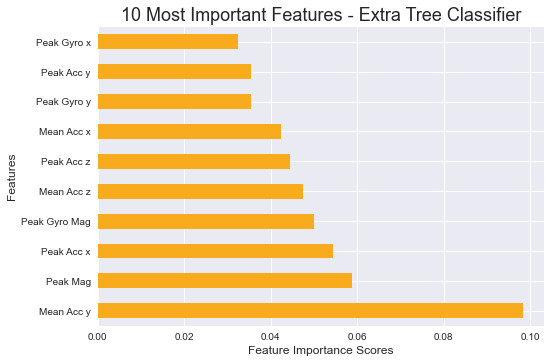

In [8]:
model = ExtraTreesClassifier()
model.fit(X_df1, Y_1)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
plt.style.use('seaborn')
feat_importances = pd.Series(model.feature_importances_, index=X_df1.columns)
feat_importances.nlargest(10).plot(kind='barh', color= '#f8ab1c')
plt.title('10 Most Important Features - Extra Tree Classifier', fontsize=18)
plt.xlabel('Feature Importance Scores', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

### 4.3) Removing Features

In [9]:
#Removing Features not found in either model from the dataframe and creating new data split
X_df1 = X_df1.drop(['Duration', 'Mean Gyro x', 'Mean Gyro y', 'Mean Gyro z', 'Peak Speed', 'N Mag Peaks', 'N Gyro Mag Peaks', 'Mean Speed', 'Mag Speed', 'tempmin', 'temp', 'dew', 'humidity', 'tempmax', 'precip', 'snow', 'windspeed', 'winddir', 'visibility', 'uvindex'], axis=1)

X_train_df1, X_test_df1, y_train_df1, y_test_df1 = train_test_split(X_df1, Y_1, test_size=0.3, random_state=42)

### 4.4) Univariate Selection (Goalkeeper Dives)

In [10]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X_df2, Y_2)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X_df2.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

"""
Title: Discovering the shades of Feature Selection Methods
Author: Manoj, S
Date: 2021
Availability: https://www.analyticsvidhya.com/blog/2021/04/discovering-the-shades-of-feature-selection-methods/
"""

          Specs       Score
2    Mean Acc x  479.926435
1    Peak Acc x  408.863369
12  Mean Gyro z  278.285139
4    Mean Acc y  155.695905
19    Mag Speed  145.265480
17   Peak Speed  131.429408
18   Mean Speed  131.429408
5    Peak Acc z  127.220085
9   Peak Gyro y  124.740343
13     Peak Mag  116.858868


C:\Users\darag\Anaconda1\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:114: UserWarning: Features [31] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
C:\Users\darag\Anaconda1\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


'\nTitle: Discovering the shades of Feature Selection Methods\nAuthor: Manoj, S\nDate: 2021\nAvailability: https://www.analyticsvidhya.com/blog/2021/04/discovering-the-shades-of-feature-selection-methods/\n'

### 4.5) Extra Tree Classification (Goalkeeper Dives)

[0.02121024 0.08422063 0.09749724 0.02683094 0.04786963 0.04161562
 0.03951362 0.01971137 0.02900218 0.03311923 0.03920917 0.0299077
 0.06040679 0.02287206 0.02476619 0.02399198 0.03032658 0.02972825
 0.02851985 0.03483237 0.01741867 0.01632431 0.02376313 0.01537169
 0.02017921 0.01419774 0.0134357  0.01524274 0.01315992 0.01451218
 0.01492301 0.         0.01532764 0.01442034 0.01497315 0.0115989 ]


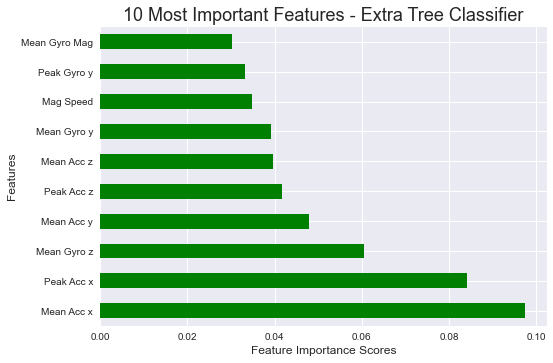

In [11]:
model = ExtraTreesClassifier()
model.fit(X_df2, Y_2)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
plt.style.use('seaborn')
feat_importances = pd.Series(model.feature_importances_, index=X_df2.columns)
feat_importances.nlargest(10).plot(kind='barh', color= 'green')
plt.title('10 Most Important Features - Extra Tree Classifier', fontsize=18)
plt.xlabel('Feature Importance Scores', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

### 4.6) Removing Features

In [12]:
#Removing Features not found in either model from the dataframe and creating new data split
X_df2 = X_df2.drop(['Duration', 'Mean Gyro x', 'Peak Gyro x', 'Peak Mag', 'Mean Mag', 'Peak Gyro Mag', 'Peak Acceleration (m/s2)', 'N Mag Peaks', 'N Gyro Mag Peaks', 'tempmin', 'temp', 'dew', 'humidity', 'tempmax', 'precip', 'snow', 'windspeed', 'winddir', 'visibility', 'uvindex'], axis=1)

X_train_df2, X_test_df2, y_train_df2, y_test_df2 = train_test_split(X_df2, Y_2, test_size=0.3, random_state=42)

## 5) Feature Extraction

### 5.1) Elbow Method (Goalkeeper Actions)

C:\Users\darag\AppData\Local\Temp/ipykernel_35504/1493911901.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, Variance_1, 'bx-', color = '#f8ab1c')


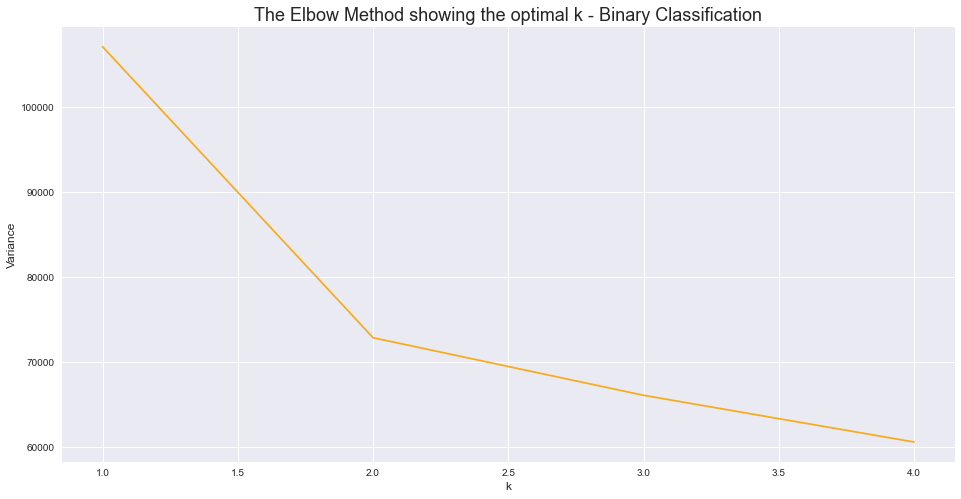

'\nTitle: sklearn k-Means (Elbow and Silhouette Method)\nAuthor: Naik, K\nDate: 2022\nAvailability: https://www.kaggle.com/code/funxexcel/p2-sklearn-k-means-elbow-and-silhouette-method/notebook\n'

In [13]:
#create list to hold Variance values for each k value
Variance_1 = []
K = range(1,5)
#loop to fit KMeans to the binary data k between 1 and 5
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_df1)
    Variance_1.append(kmeanModel.inertia_)
    
#Plot k Values     
plt.figure(figsize=(16,8))
plt.plot(K, Variance_1, 'bx-', color = '#f8ab1c')
plt.xlabel('k', fontsize=12)
plt.ylabel('Variance', fontsize=12)
plt.title('The Elbow Method showing the optimal k - Binary Classification', fontsize=18)
sns.despine()
plt.show()

"""
Title: sklearn k-Means (Elbow and Silhouette Method)
Author: Naik, K
Date: 2022
Availability: https://www.kaggle.com/code/funxexcel/p2-sklearn-k-means-elbow-and-silhouette-method/notebook
"""

### 5.2) Silhouette Scores (Goalkeeper Actions Data)

Silhouette score for k(clusters) = 2 is 0.4010159405983497
Silhouette score for k(clusters) = 3 is 0.25928392772481273
Silhouette score for k(clusters) = 4 is 0.2946118666709067
Silhouette score for k(clusters) = 5 is 0.20613843362323434
   Clusters  Sil Score
0         2   0.401016
1         3   0.259284
2         4   0.294612
3         5   0.206138


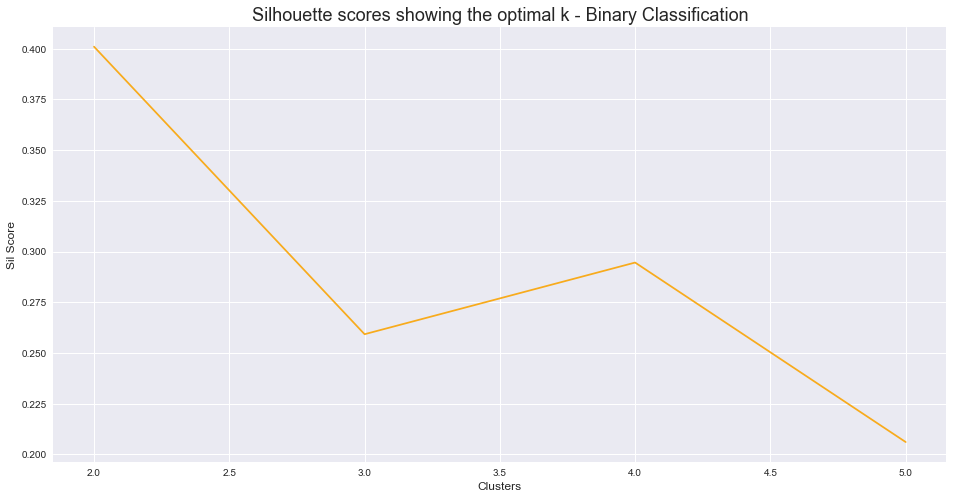

'\nTitle: sklearn k-Means (Elbow and Silhouette Method)\nAuthor: Naik, K\nDate: 2022\nAvailability: https://www.kaggle.com/code/funxexcel/p2-sklearn-k-means-elbow-and-silhouette-method/notebook\n'

In [14]:

SK = range(2,6)
sil_score = []
for i in SK:
    labels=KMeans(n_clusters=i,init="k-means++",random_state=200).fit(X_df1).labels_
    score = metrics.silhouette_score(X_df1,labels,metric="euclidean",sample_size=1000,random_state=200)
    sil_score.append(score)
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(X_df1,labels,metric="euclidean",sample_size=1000,random_state=200)))

sil_centers = pd.DataFrame({'Clusters' : SK, 'Sil Score' : sil_score})
print(sil_centers)

plt.figure(figsize=(16,8))
plt.plot(sil_centers['Clusters'], sil_centers['Sil Score'], color = '#f8ab1c')
plt.xlabel('Clusters', fontsize=12)
plt.ylabel('Sil Score', fontsize=12)
plt.title('Silhouette scores showing the optimal k - Binary Classification', fontsize=18)
plt.show()

"""
Title: sklearn k-Means (Elbow and Silhouette Method)
Author: Naik, K
Date: 2022
Availability: https://www.kaggle.com/code/funxexcel/p2-sklearn-k-means-elbow-and-silhouette-method/notebook
"""

### 5.3) Principal Component Ananlysis (Goalkeeper Actions Data)

In [15]:
pca1 = PCA(n_components=2)
X_pc1 = pca1.fit_transform(X_df1)
X_pca1 = pd.DataFrame(data = X_pc1, columns = ['principal component 1', 'principal component 2'])

X_train_pca1, X_test_pca1, y_train_pca1, y_test_pca1 = train_test_split(X_pca1, Y_1, test_size=0.3, random_state=42)

### 5.4) Elbow Method (Goalkeeper Dives Data)

C:\Users\darag\AppData\Local\Temp/ipykernel_35504/1477396930.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, Variance_2, 'bx-', color = 'green')


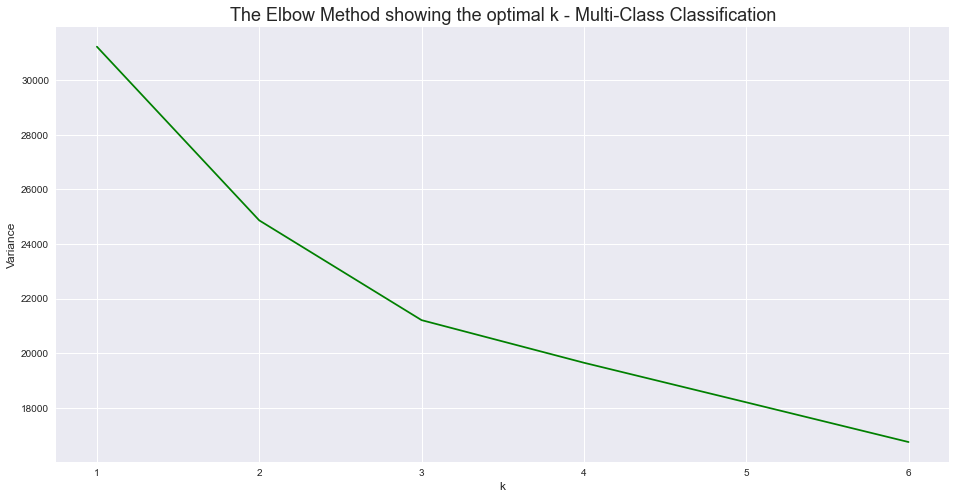

'\nTitle: sklearn k-Means (Elbow and Silhouette Method)\nAuthor: Naik, K\nDate: 2022\nAvailability: https://www.kaggle.com/code/funxexcel/p2-sklearn-k-means-elbow-and-silhouette-method/notebook\n'

In [30]:
Variance_2 = []
K = range(1,7)
#loop to fit KMeans to the binary data k between 1 and 7
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_df2)
    Variance_2.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, Variance_2, 'bx-', color = 'green')
plt.xlabel('k', fontsize=12)
plt.ylabel('Variance', fontsize=12)
plt.title('The Elbow Method showing the optimal k - Multi-Class Classification', fontsize=18)
plt.show()

"""
Title: sklearn k-Means (Elbow and Silhouette Method)
Author: Naik, K
Date: 2022
Availability: https://www.kaggle.com/code/funxexcel/p2-sklearn-k-means-elbow-and-silhouette-method/notebook
"""

### 5.5) Silhouette Scores (Goalkeeper Dives Data)

Silhouette score for k(clusters) = 2 is 0.1942840275367636
Silhouette score for k(clusters) = 3 is 0.2020471268108928
Silhouette score for k(clusters) = 4 is 0.21213979589912355
Silhouette score for k(clusters) = 5 is 0.18794777292838888
   Clusters  Sil Score
0         2   0.194284
1         3   0.202047
2         4   0.212140
3         5   0.187948


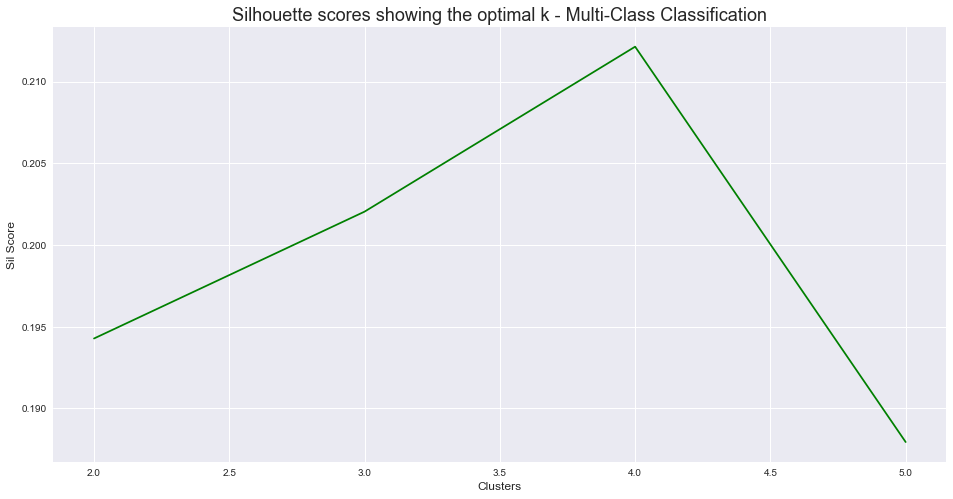

'\nTitle: sklearn k-Means (Elbow and Silhouette Method)\nAuthor: Naik, K\nDate: 2022\nAvailability: https://www.kaggle.com/code/funxexcel/p2-sklearn-k-means-elbow-and-silhouette-method/notebook\n'

In [31]:
SK = range(2,6)
sil_score = []
for i in SK:
    labels=KMeans(n_clusters=i,init="k-means++",random_state=200).fit(X_df2).labels_
    score = metrics.silhouette_score(X_df2,labels,metric="euclidean",sample_size=1000,random_state=200)
    sil_score.append(score)
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(metrics.silhouette_score(X_df2,labels,metric="euclidean",sample_size=1000,random_state=200)))

sil_centers = pd.DataFrame({'Clusters' : SK, 'Sil Score' : sil_score})
print(sil_centers)

plt.figure(figsize=(16,8))
plt.plot(sil_centers['Clusters'], sil_centers['Sil Score'], color = 'green')
plt.xlabel('Clusters', fontsize=12)
plt.ylabel('Sil Score', fontsize=12)
plt.title('Silhouette scores showing the optimal k - Multi-Class Classification', fontsize=18)
plt.show()

"""
Title: sklearn k-Means (Elbow and Silhouette Method)
Author: Naik, K
Date: 2022
Availability: https://www.kaggle.com/code/funxexcel/p2-sklearn-k-means-elbow-and-silhouette-method/notebook
"""

### 5.6) Principal Component Ananlysis (Goalkeeper Actions Data)

In [18]:
pca2 = PCA(n_components=4)
X_pc2 = pca2.fit_transform(X_df2)
X_pca2 = pd.DataFrame(data = X_pc2, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])

X_train_pca2, X_test_pca2, y_train_pca2, y_test_pca2 = train_test_split(X_pca2, Y_2, test_size=0.3, random_state=42)

## 6) Building Models

In [19]:
#Cross Validation & Machine learning Algorithms

#function for creating Logistic Regression Classification models with specific hyper parameters
def Log_Reg_Models(x, y, C, penalty):
    
  kf = KFold(n_splits=5)
  #Logistic Regression Models        
  logreg = LogisticRegression(C= C, penalty= penalty)
  y_pred1 = cross_val_predict(logreg, x, y, cv= kf)
  print('Logistic Regression Model Validation Results:')
  print(classification_report(y, y_pred1))
  logreg.fit(x, y)
  return logreg

#function for creating kNN Classification models with specific hyper parameters
def Knn_Models(x, y, n, p, w):        
  
  kf = KFold(n_splits=5)  
  #KNN Classification Models
  knn = KNeighborsClassifier(n_neighbors=n, p=p, weights=w)
  y_pred3 = cross_val_predict(knn, x, y, cv= kf)
  print('KNN Classification Model Validation Results:')
  print(classification_report(y, y_pred3))
  knn.fit(x, y)
  return knn

#function for creating Deciscion Tree Classification models with specific hyper parameters
def Dtree_Models(x, y, d, l, s):
  
  kf = KFold(n_splits=5)  
  #Decision Tree Models
  dtree = DecisionTreeClassifier(max_depth= d, min_samples_leaf = l, min_samples_split = s, class_weight=('balanced'))
  y_pred4 = cross_val_predict(dtree, x, y, cv= kf)
  print('Decision Tree Model Validation Results:')
  print(classification_report(y, y_pred4))
  dtree.fit(x, y)
  return dtree

#function for creating Support Vector Classifier Classification models with specific hyper parameters
def SVC_Models(x, y, c, g):
  
  kf = KFold(n_splits=5)  
  #Support Vector Classifier Models
  clf = SVC(C= c, gamma= g, kernel='rbf')
  y_pred5 = cross_val_predict(clf, x, y, cv= kf)
  print('Support Vector Classifier Model Validation Results:')
  print(classification_report(y, y_pred5))
  clf.fit(x, y)
  return clf
  
#function for creating Random Forest Classification models with specific hyper parameters  
def RanF_Models(x, y, n, d, f):
  
  kf = KFold(n_splits=5)  
  #Random Forest Models
  rfc = RandomForestClassifier(n_estimators = n, max_depth = d, max_features = f, bootstrap = True, class_weight = 'balanced', random_state = 11)
  y_pred6 = cross_val_predict(rfc, x, y, cv= kf)
  print('Random forest Model Validation Results:')
  print(classification_report(y, y_pred6))
  rfc.fit(x, y)
  return rfc

#function for calculating models metrics
def Model_Results(y_test, y_pred):
  print('Accuracy:', accuracy_score(y_test, y_pred))
  print('Precision:', precision_score(y_test, y_pred, average='weighted'))
  print('Recall:', recall_score(y_test, y_pred, average='weighted'))
  print('F1-score:', f1_score(y_test, y_pred, average='weighted'))

## 7) Training and Testing Models/ Grid Search

### 7.1) Grid Search for Logistic Reression

In [20]:
#Grid search to find the best parameters and score for Logistic Regression
logreg = LogisticRegression()
log_params = [{'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}]
grid_search = GridSearchCV(logreg, log_params, cv = 5, scoring='accuracy')
grid_search.fit(X_train_pca2, y_train2)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

C:\Users\darag\Anaconda1\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\darag\Anaconda1\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\darag\Anaconda1\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\darag\Anaconda1\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\darag\Anaconda1\lib\site-packages\sklearn\model_selection\_v

C:\Users\darag\Anaconda1\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\darag\Anaconda1\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\darag\Anaconda1\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\darag\Anaconda1\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\darag\Anaconda1\lib\site-packages\sklearn\model_selection\_v

Best parameters:  {'C': 1, 'penalty': 'l2'}
Best score:  0.6764204165664018


C:\Users\darag\Anaconda1\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.67276276        nan 0.67642042        nan 0.67495789]
  warnings.warn(


### 7.2) Logistic Regression Models

In [21]:
#Original Dataset with minimal Pre-Processing
print('Original Dataset with minimal Pre-Processing')
LogR_1 = Log_Reg_Models(X_train1, y_train1, 0.1, 'l2')
LogR_Pred1 = LogR_1.predict(X_test1)
Model_Results(y_test1, LogR_Pred1)

LogR_2 = Log_Reg_Models(X_train2, y_train2, 10, 'l2')
LogR_Pred2 = LogR_2.predict(X_test2)
Model_Results(y_test2, LogR_Pred2)

#Feature Selection Dataset with Standerdization
print('Feature Selection Dataset with Standerdization')
LogR_1 = Log_Reg_Models(X_train_df1, y_train1, 1, 'l2')
LogR_Pred1 = LogR_1.predict(X_test_df1)
Model_Results(y_test1, LogR_Pred1)

LogR_2 = Log_Reg_Models(X_train_df2, y_train2, 1, 'l2')
LogR_Pred2 = LogR_2.predict(X_test_df2)
Model_Results(y_test2, LogR_Pred2)

#PCA Dataset with Feature selection
print('PCA Dataset with Feature selection')
LogR_1 = Log_Reg_Models(X_train_pca1, y_train1, 1, 'l2')
LogR_Pred1 = LogR_1.predict(X_test_pca1)
Model_Results(y_test1, LogR_Pred1)

LogR_2 = Log_Reg_Models(X_train_pca2, y_train2, 1, 'l2')
LogR_Pred2 = LogR_2.predict(X_test_pca2)
Model_Results(y_test2, LogR_Pred2)

Original Dataset with minimal Pre-Processing


C:\Users\darag\Anaconda1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\darag\Anaconda1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Logistic Regression Model Validation Results:
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87      3324
         1.0       0.72      0.58      0.64      1361

    accuracy                           0.81      4685
   macro avg       0.78      0.74      0.76      4685
weighted avg       0.81      0.81      0.81      4685



C:\Users\darag\Anaconda1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8072709163346613
Precision: 0.8007730608976374
Recall: 0.8072709163346613
F1-score: 0.8004362506322985


C:\Users\darag\Anaconda1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\darag\Anaconda1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Logistic Regression Model Validation Results:
              precision    recall  f1-score   support

         1.0       0.60      0.35      0.45       133
         3.0       0.62      0.45      0.52       117
         5.0       0.73      0.83      0.78       379
         7.0       0.70      0.79      0.74       387
        10.0       0.60      0.58      0.59        98
        11.0       0.53      0.52      0.53        88
        13.0       0.56      0.54      0.55       164

    accuracy                           0.67      1366
   macro avg       0.62      0.58      0.59      1366
weighted avg       0.66      0.67      0.66      1366



C:\Users\darag\Anaconda1\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6621160409556314
Precision: 0.6591880410833881
Recall: 0.6621160409556314
F1-score: 0.649073555975178
Feature Selection Dataset with Standerdization
Logistic Regression Model Validation Results:
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.89      3324
         1.0       0.73      0.72      0.72      1361

    accuracy                           0.84      4685
   macro avg       0.81      0.80      0.81      4685
weighted avg       0.84      0.84      0.84      4685

Accuracy: 0.8162350597609562
Precision: 0.8144115865987467
Recall: 0.8162350597609562
F1-score: 0.8152052269314602
Logistic Regression Model Validation Results:
              precision    recall  f1-score   support

         1.0       0.60      0.51      0.55       133
         3.0       0.70      0.49      0.57       117
         5.0       0.79      0.86      0.82       379
         7.0       0.77      0.82      0.79       387
        10.0       0.64      0.77 

### 7.3) Grid Search for kNN

In [22]:
#Grid search to find the best parameters and score for kNN
knn = KNeighborsClassifier()
knn_params = [{'n_neighbors': [3, 5, 7, 9, 13, 17], 'weights': ['uniform', 'distance'], 
              'p': [1, 2, 3]}]
grid_search = GridSearchCV(knn, knn_params, cv = 5, scoring='accuracy')
grid_search.fit(X_train_pca2, y_train2)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'n_neighbors': 17, 'p': 2, 'weights': 'distance'}
Best score:  0.7276409721665196


### 7.4) k-Nearest Neighbor Models

In [23]:
#Original Dataset with minimal Pre-Processing
print('Original Dataset with minimal Pre-Processing')
KNN_1 = Knn_Models(X_train1, y_train1, 9, 1, 'distance')
KNN_Pred1 = KNN_1.predict(X_test1)
Model_Results(y_test1, KNN_Pred1)

KNN_2 = Knn_Models(X_train2, y_train2, 7, 1, 'distance')
KNN_Pred2 = KNN_2.predict(X_test2)
Model_Results(y_test2, KNN_Pred2)

#Feature Selection Dataset with Standerdization
print('Feature Selection Dataset with Standerdization')
KNN_1 = Knn_Models(X_train_df1, y_train1, 9, 1, 'distance')
KNN_Pred1 = KNN_1.predict(X_test_df1)
Model_Results(y_test1, KNN_Pred1)

KNN_2 = Knn_Models(X_train_df2, y_train2, 3, 1, 'distance')
KNN_Pred2 = KNN_2.predict(X_test_df2)
Model_Results(y_test2, KNN_Pred2)

#PCA Dataset with Feature selection
print('PCA Dataset with Feature selection')
KNN_1 = Knn_Models(X_train_pca1, y_train1, 17, 1, 'uniform')
KNN_Pred1 = KNN_1.predict(X_test_pca1)
Model_Results(y_test1, KNN_Pred1)

KNN_2 = Knn_Models(X_train_pca2, y_train2, 17, 2, 'distance')
KNN_Pred2 = KNN_2.predict(X_test_pca2)
Model_Results(y_test2, KNN_Pred2)

Original Dataset with minimal Pre-Processing
KNN Classification Model Validation Results:
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87      3324
         1.0       0.70      0.60      0.65      1361

    accuracy                           0.81      4685
   macro avg       0.77      0.75      0.76      4685
weighted avg       0.80      0.81      0.80      4685

Accuracy: 0.8002988047808764
Precision: 0.7933592963825717
Recall: 0.8002988047808764
F1-score: 0.7937651503759572
KNN Classification Model Validation Results:
              precision    recall  f1-score   support

         1.0       0.47      0.35      0.40       133
         3.0       0.49      0.40      0.44       117
         5.0       0.73      0.79      0.76       379
         7.0       0.68      0.73      0.70       387
        10.0       0.58      0.71      0.64        98
        11.0       0.46      0.62      0.53        88
        13.0       0.71      0.48      0.57 

### 7.5) Grid Search for Decision Tree

In [24]:
#Grid search to find the best parameters and score for Decision Trees
dtree = DecisionTreeClassifier()
dtree_params = [{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_leaf': [1, 2, 3, 4, 5]}]
grid_search = GridSearchCV(dtree, dtree_params, cv = 5, scoring='accuracy')
grid_search.fit(X_train_pca2, y_train2)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 4}
Best score:  0.6851982567311035


### 7.6) Decision Tree Models

In [25]:
#Original Dataset with minimal Pre-Processing
print('Original Dataset with minimal Pre-Processing')
Dtree_1 = Dtree_Models(X_train1, y_train1, 5, 1, 7)
Dtree_Pred1 = Dtree_1.predict(X_test1)
Model_Results(y_test1, Dtree_Pred1)

Dtree_2 = Dtree_Models(X_train2, y_train2, 8, 1, 4)
Dtree_Pred2 = Dtree_2.predict(X_test2)
Model_Results(y_test2, Dtree_Pred2)

#Feature Selection Dataset with Standerdization
print('Feature Selection Dataset with Standerdization')
Dtree_1 = Dtree_Models(X_train_df1, y_train1, 4, 1, 5)
Dtree_Pred1 = Dtree_1.predict(X_test_df1)
Model_Results(y_test1, Dtree_Pred1)

Dtree_2 = Dtree_Models(X_train_df2, y_train2, 6, 4, 9)
Dtree_Pred2 = Dtree_2.predict(X_test_df2)
Model_Results(y_test2, Dtree_Pred2)

#PCA Dataset with Feature selection
print('PCA Dataset with Feature selection')
Dtree_1 = Dtree_Models(X_train_pca1, y_train1, 5, 4, 3)
Dtree_Pred1 = Dtree_1.predict(X_test_pca1)
Model_Results(y_test1, Dtree_Pred1)

Dtree_2 = Dtree_Models(X_train_pca2, y_train2, 6, 2, 5)
Dtree_Pred2 = Dtree_2.predict(X_test_pca2)
Model_Results(y_test2, Dtree_Pred2)

Original Dataset with minimal Pre-Processing
Decision Tree Model Validation Results:
              precision    recall  f1-score   support

         0.0       0.93      0.81      0.86      3324
         1.0       0.65      0.84      0.73      1361

    accuracy                           0.82      4685
   macro avg       0.79      0.83      0.80      4685
weighted avg       0.84      0.82      0.83      4685

Accuracy: 0.7868525896414342
Precision: 0.8218367933777618
Recall: 0.7868525896414342
F1-score: 0.7942939937970686
Decision Tree Model Validation Results:
              precision    recall  f1-score   support

         1.0       0.55      0.65      0.60       133
         3.0       0.44      0.62      0.52       117
         5.0       0.83      0.72      0.77       379
         7.0       0.81      0.68      0.74       387
        10.0       0.72      0.78      0.75        98
        11.0       0.45      0.61      0.52        88
        13.0       0.66      0.66      0.66       164


### 7.7) Grid Search for Support Vector Classifier

In [26]:
#Grid search to find the best parameters and score for SVC
svc = SVC()
svc_params = [{'gamma': [0.001, 0.01, 0.1, 1, 'scale', 'auto']}]
grid_search = GridSearchCV(svc, svc_params, cv = 5, scoring='accuracy')
grid_search.fit(X_train_pca2, y_train2)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'gamma': 'auto'}
Best score:  0.7254618860458277


### 7.8) Support Vector Classifier Models

In [27]:
#Original Dataset with minimal Pre-Processing
print('Original Dataset with minimal Pre-Processing')
SVC_1 = SVC_Models(X_train1, y_train1, 100, 'scale')
SVC_Pred1 = SVC_1.predict(X_test1)
Model_Results(y_test1, SVC_Pred1)

SVC_2 = SVC_Models(X_train2, y_train2, 100, 'scale')
SVC_Pred2 = SVC_2.predict(X_test2)
Model_Results(y_test2, SVC_Pred2)

#Feature Selection Dataset with Standerdization
print('Feature Selection Dataset with Standerdization')
SVC_1 = SVC_Models(X_train_df1, y_train1, 1, 0.1, )
SVC_Pred1 = SVC_1.predict(X_test_df1)
Model_Results(y_test1, SVC_Pred1)

SVC_2 = SVC_Models(X_train_df2, y_train2, 1, 'scale')
SVC_Pred2 = SVC_2.predict(X_test_df2)
Model_Results(y_test2, SVC_Pred2)

#PCA Dataset with Feature selection
print('PCA Dataset with Feature selection')
SVC_1 = SVC_Models(X_train_pca1, y_train1, 100, 'auto')
SVC_Pred1 = SVC_1.predict(X_test_pca1)
Model_Results(y_test1, SVC_Pred1)

SVC_2 = SVC_Models(X_train_pca2, y_train2, 1, 'auto')
SVC_Pred2 = SVC_2.predict(X_test_pca2)
Model_Results(y_test2, SVC_Pred2)

Original Dataset with minimal Pre-Processing
Support Vector Classifier Model Validation Results:
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      3324
         1.0       0.73      0.62      0.67      1361

    accuracy                           0.82      4685
   macro avg       0.79      0.76      0.78      4685
weighted avg       0.82      0.82      0.82      4685

Accuracy: 0.8107569721115537
Precision: 0.8049869916658825
Recall: 0.8107569721115537
F1-score: 0.8056283478360395
Support Vector Classifier Model Validation Results:
              precision    recall  f1-score   support

         1.0       0.62      0.48      0.54       133
         3.0       0.58      0.43      0.49       117
         5.0       0.77      0.83      0.80       379
         7.0       0.73      0.79      0.76       387
        10.0       0.61      0.68      0.65        98
        11.0       0.60      0.60      0.60        88
        13.0       0.65      0

### 7.9) Grid Search for Random Forest

In [28]:
#Grid search to find the best parameters and score for Random Forest
rfc = RandomForestClassifier()
rfc_params = [{'n_estimators': [100, 300, 500, 700]}]
grid_search = GridSearchCV(rfc, rfc_params, cv = 5, scoring='accuracy')
grid_search.fit(X_train_pca2, y_train2)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'n_estimators': 300}
Best score:  0.7291248897088314


### 7.10) Random Forest Models

In [29]:
#Original Dataset with minimal Pre-Processing
print('Original Dataset with minimal Pre-Processing')
RanF_1 = RanF_Models(X_train1, y_train1, 500, 9, None)
RanF_Pred1 = RanF_1.predict(X_test1)
Model_Results(y_test1, RanF_Pred1)

RanF_2 = RanF_Models(X_train2, y_train2, 500, None, 'log2')
RanF_Pred2 = RanF_2.predict(X_test2)
Model_Results(y_test2, RanF_Pred2)

#Feature Selection Dataset with Standerdization
print('Feature Selection Dataset with Standerdization')
RanF_1 = RanF_Models(X_train_df1, y_train1, 700, 7, None)
RanF_Pred1 = RanF_1.predict(X_test_df1)
Model_Results(y_test1, RanF_Pred1)

RanF_2 = RanF_Models(X_train_df2, y_train2, 300, None, 'log2')
RanF_Pred2 = RanF_2.predict(X_test_df2)
Model_Results(y_test2, RanF_Pred2)

#PCA Dataset with Feature selection
print('PCA Dataset with Feature selection')
RanF_1 = RanF_Models(X_train_pca1, y_train1, 300, 7, 'sqrt')
RanF_Pred1 = RanF_1.predict(X_test_pca1)
Model_Results(y_test1, RanF_Pred1)

RanF_2 = RanF_Models(X_train_pca2, y_train2, 700, 7, 'log2')
RanF_Pred2 = RanF_2.predict(X_test_pca2)
Model_Results(y_test2, RanF_Pred2)
              

Original Dataset with minimal Pre-Processing
Random forest Model Validation Results:
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      3324
         1.0       0.73      0.81      0.77      1361

    accuracy                           0.86      4685
   macro avg       0.82      0.84      0.83      4685
weighted avg       0.86      0.86      0.86      4685

Accuracy: 0.8401394422310757
Precision: 0.8447918979810153
Recall: 0.8401394422310757
F1-score: 0.8418863026753877
Random forest Model Validation Results:
              precision    recall  f1-score   support

         1.0       0.87      0.59      0.70       133
         3.0       0.87      0.53      0.66       117
         5.0       0.83      0.90      0.86       379
         7.0       0.80      0.89      0.84       387
        10.0       0.83      0.93      0.88        98
        11.0       0.76      0.75      0.75        88
        13.0       0.78      0.77      0.78       164
